# Topic Modelling


Importing all the required packages 

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
import nltk


In [ ]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
cd /content/drive/My Drive/FIT5212

/content/drive/My Drive/FIT5212


We were given a news dataset which is related to the Monash University. We are preforming the LDA on this dataset to find out what sort of new topics are these and how these are related to the Monash University

#### Read the news data into dataframe


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
tp_df = pd.read_csv("Monash_crawled.csv")
tp_df.head(2)

,uri,url,date,title,body
0,1395271488,http://www.theguardian.com/environment/2020/ja...,2020-01-01,Canberra experiences worst air quality on reco...,Canberra\n has experienced its worst air qual...
1,1396563053,https://weather.com/news/news/2020-01-02-thous...,2020-01-02,Thousands Clog Roads Fleeing Australian Bushfi...,As\n dawn broke over a blackened Australi...


In [ ]:
print("Shape of the dataframe:",tp_df.shape)
print("Columns of the dataset are:", tp_df.columns)

Shape of the dataframe: (482, 5)
Columns of the dataset are: Index(['uri', 'url', 'date', 'title', 'body'], dtype='object')


Check if we have any null or NaN values in the dataset.

In [ ]:
tp_df[tp_df.isnull().any(axis=1)]


,uri,url,date,title,body


We can see that there are no null rows in the dataset, we are good to proceed further.

### Preprocessing the text

We do the basic preprocessing then see what are all the tokens and see if we need any more processing with respect to the data so that we can make the data more clear to the model for training

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def pre_process_lda(row):
  """
  function name: pre_process_lda
  Arguments: 1, row
  Description: This function will perform tokenization, remove all special characters and numbers from the string
               lowers the words, remove stopwords from the text and selects only word which are of have 1 or more character in it
  Return Value: A clean processed abstract list
  """
  string = row['body']
  tokens_lda = word_tokenize(string) #tokenizing the sentence
  tokens_with_no_punc_lda = [re.sub('[^A-Za-z]+', ' ', char.lower()) for char in tokens_lda] #removing numbers, special characters and lowering all the text
  tokens_with_no_punc_and_lengt2_token_lda = [item for item in tokens_with_no_punc_lda if len(item)>1] #removing words which are of length less 2
  tokens_with_no_punc_and_lengt2_token_lda = [item for item in tokens_with_no_punc_and_lengt2_token_lda if item not in stopwords] #removing stopwords from the list
  return tokens_with_no_punc_and_lengt2_token_lda

tp_df["processed_text"] = tp_df.apply(lambda x: pre_process_lda(x), axis =1)
    

Lets have a look how our tokens are created. 
- Are all them good? 
- do we need more pre processing? 
- do we need more stopwords list in terms of this data?

In [ ]:
lda_tokens = tp_df["processed_text"].tolist()
lda_tokens = [item.lower() for sublist in lda_tokens for item in sublist]

In [ ]:
from nltk.probability import FreqDist
#print("Number of Unique tokens we have are: ",len(set(lda_tokens)))
freq_lda = FreqDist(lda_tokens)
freq_lda.most_common(50)

[(' s', 7525),
 ('march', 5100),
 ('coronavirus', 5072),
 ('man', 4539),
 ('confirmed', 4192),
 ('woman', 4091),
 (' year old', 4088),
 ('diagnosed', 3395),
 ('february', 3295),
 ('australia', 3227),
 ('january', 2836),
 ('also', 2796),
 ('hospital', 2593),
 ('case', 2394),
 ('positive', 2285),
 ('said', 2234),
 ('cases', 2075),
 ('two', 2029),
 ('virus', 1970),
 ('health', 1950),
 ('people', 1873),
 ('returned', 1825),
 ('sydney', 1809),
 ('new', 1787),
 ('tested', 1739),
 ('china', 1660),
 ('aged', 1513),
 ('south', 1494),
 ('travelled', 1476),
 ('iran', 1466),
 ('melbourne', 1457),
 ('recently', 1362),
 ('contact', 1277),
 ('queensland', 1269),
 ('wuhan', 1240),
 ('chinese', 1228),
 ('one', 1227),
 ('university', 1191),
 ('australian', 1182),
 ('flight', 1179),
 ('via', 1059),
 ('returning', 1055),
 ('care', 1031),
 ('first', 1031),
 ('nsw', 1006),
 ('covid ', 947),
 ('another', 916),
 ('close', 901),
 ('arrived', 884),
 ('brisbane', 881)]

We can see that the top word in our token is **(space)s** this might have happened because of the special characted **'** has been removed.
- There are few more words like *year old*, we need to split these aswell
-  Trimming the spaces will help us in reducing the number of tokens of lenght less than 2.

So we do a second run of preprocessing with above mentioned steps.

But before that lets see how our processed tokes look like

In [ ]:
tp_df["processed_text"]

0      [canberra, experienced, worst, air, quality, r...
1      [dawn, broke, blackened, australian, landscape...
2      [baby,  s, brain, body, grow, lot, first, six,...
3      [living, polluted, cities, may, make, bones, w...
4      [researchers, developed, new, battery, claim, ...
                             ...                        
477    [published, aedt, march, updated, aedt, march,...
478    [published, aedt, march, updated, aedt, march,...
479    [published, aedt, march, updated, aedt, march,...
480    [published, aedt, march, updated, aedt, march,...
481    [spider, resembles, vincent, van, gogh,  s, fa...
Name: processed_text, Length: 482, dtype: object

In [ ]:
tp_df["body"][478]

'    Published:    10:20 AEDT, 31 March 2020     |    Updated:    10:20 AEDT, 31 March 2020        Claims\n the spread of COVID-19 could be suppressed like influenza by regulating\n indoor humidity need to be investigated, say Australian experts.   The\n theory is based on 2013 research showing patients are safer from the \nflu in a room set at higher relative humidity than a dry one.   The\n US Centers for Disease Control and Prevention study found more than 75 \nper cent of influenza particles were able to cause infection an hour \nafter being coughed into an area where humidity levels were 23 per cent.   When the levels were raised to 43 per cent, just 14 per cent of the particles were infectious.   While\n potentially significant, Adelaide University Research Centre for \nInfectious Disease deputy director Michael Beard says the idea \nhumidification might subdue COVID-19 needs analysis.   "It seems to\n be that this virus is a little bit hardier or a little more resistant \nto som

We see that some of the ending documents have words like **`published, aedt, march, updated......`**as there are mostly related to when the news has been released and doesn't really contribute to the model. We can consider these as the stopwords and remove from the vocabulary.


*`published`* - is giving the details when it is published and contains the time and day.
Since we removed the numbers and special characters in the first pre processing step, we only need to remove some other words like timezone **`(aedt)`** and the month names like **`(march, january, august etc.,)`**



In [ ]:
new_stopwords  = ["published","aedt","updated","january","february","march","april","may","june","july","august","september","october","november","december","also","said","could","told","and","also","should","would",'go', 'get', 'from',  'done','subject', 're','do']
stopwords = stopwords + new_stopwords

Added few more stopwords to our list in order to obtain more clean data.

In the second run of preprocessing we are doing the follow steps:
1.  Splitting the words which has space in between them and considered as one token
2. Stripping starting and ending spaces to get the more clearly length of each word
3. Again removing the words of length less than 2
4. Removing the new stopwords that we found in the dataset. These stopwords are particular to this dataset

In [ ]:

stopwords = stopwords
def second_process_ld(row):
  str_lda = row["processed_text"]
  second_tokens_lda = [char.split(' ') for char in str_lda]
  second_tokens_lda = [item for sublist in second_tokens_lda for item in sublist] #flatten the list
  second_tokens_lda = [char.strip() for char in second_tokens_lda]
  second_tokens_lda = [char for char in second_tokens_lda if len(char) > 1]
  second_tokens_lda = [char for char in second_tokens_lda if char not in stopwords]
  return second_tokens_lda

tp_df["full_processed"] = tp_df.apply(lambda x: second_process_ld(x), axis = 1)


Since we are seeing lot of words about corona in differen forms i am trying to normalize them into one form 

Converting **Covid, coronavirus** to **corona**

In [ ]:
import re
def normalizing_corona(row):
    new_list = []
    my_list = row["full_processed"]
    #print(my_list)
    for i in my_list:
        i = re.sub(r'coronavirus','corona',i)
        i = re.sub(r'covid','corona',i)
     
        new_list.append(i)
        #print(new_list)
    return new_list
tp_df["new_full_processed"] = tp_df.apply(lambda x: normalizing_corona(x), axis = 1)

In [ ]:
tp_df["full_processed"]

0      [canberra, experienced, worst, air, quality, r...
1      [dawn, broke, blackened, australian, landscape...
2      [baby, brain, body, grow, lot, first, six, mon...
3      [living, polluted, cities, make, bones, weaker...
4      [researchers, developed, new, battery, claim, ...
                             ...                        
477    [experts, believe, research, showing, spread, ...
478    [claims, spread, covid, suppressed, like, infl...
479    [academic, modelling, suggests, efforts, slow,...
480    [increased, social, isolation, combat, covid, ...
481    [spider, resembles, vincent, van, gogh, famous...
Name: full_processed, Length: 482, dtype: object

In [ ]:
tp_df["new_full_processed"]

0      [canberra, experienced, worst, air, quality, r...
1      [dawn, broke, blackened, australian, landscape...
2      [baby, brain, body, grow, lot, first, six, mon...
3      [living, polluted, cities, make, bones, weaker...
4      [researchers, developed, new, battery, claim, ...
                             ...                        
477    [experts, believe, research, showing, spread, ...
478    [claims, spread, corona, suppressed, like, inf...
479    [academic, modelling, suggests, efforts, slow,...
480    [increased, social, isolation, combat, corona,...
481    [spider, resembles, vincent, van, gogh, famous...
Name: new_full_processed, Length: 482, dtype: object

In [ ]:
lda_tokens_full = tp_df["new_full_processed"] .tolist()
lda_tokens_full = [item for sublist in lda_tokens_full for item in sublist]
freq_lda_full = FreqDist(lda_tokens_full)
freq_lda_full.most_common(50)


[('corona', 6092),
 ('year', 4736),
 ('man', 4548),
 ('old', 4373),
 ('confirmed', 4201),
 ('woman', 4200),
 ('diagnosed', 3395),
 ('australia', 3259),
 ('hospital', 2598),
 ('case', 2410),
 ('positive', 2287),
 ('two', 2085),
 ('cases', 2077),
 ('virus', 1982),
 ('health', 1953),
 ('people', 1886),
 ('returned', 1825),
 ('sydney', 1815),
 ('new', 1787),
 ('tested', 1743),
 ('china', 1679),
 ('south', 1520),
 ('aged', 1516),
 ('travelled', 1476),
 ('iran', 1466),
 ('melbourne', 1464),
 ('recently', 1362),
 ('one', 1281),
 ('contact', 1278),
 ('queensland', 1275),
 ('chinese', 1270),
 ('wuhan', 1240),
 ('australian', 1200),
 ('university', 1193),
 ('flight', 1183),
 ('via', 1061),
 ('returning', 1055),
 ('first', 1045),
 ('care', 1033),
 ('nsw', 1008),
 ('another', 916),
 ('close', 904),
 ('arrived', 884),
 ('brisbane', 883),
 ('female', 811),
 ('male', 799),
 ('disease', 781),
 ('three', 775),
 ('symptoms', 765),
 ('home', 738)]

In [ ]:
len(set(lda_tokens_full))

16811

Now the words makes more sense and its more clear. 

Lets create LDA model on these processed tokens

## Experiement 1: LDA model 1

For the first LDA model we are considering the following things:

1. Unigrams
2. Based on the coherence value we are taking the number of topics as 7
3. Chunksize is 2000 passing all documents at once
4. Number of iterations is 400

In [ ]:
from gensim.corpora import Dictionary
docs = tp_df["new_full_processed"]
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 16811
Number of documents: 482


### Performing the best value for the hyperparameter `number of topics` for our first experiement. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# compute coherence
words_coherence = []
for nb_topics in range(1,25):
    lda = LdaModel(corpus, num_topics = nb_topics, id2word = dictionary, passes=2)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    words_coherence.append(coh)

Text(0, 0.5, 'Coherence Score')

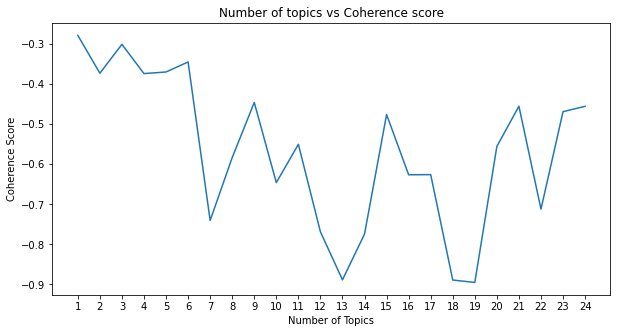

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Number of topics vs Coherence score")
plt.plot(range(1,25),words_coherence)
plt.xlabel("Number of Topics")
plt.xticks(range(1,25))
plt.ylabel("Coherence Score")

We see that for the number of topics = 9 has the value which is closer to the 0. Since we are calculating the coherence based on the `u_mass` according to this [Exploring the Space of Topic Coherence Measures](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) it says the following
- `u_mass` score values will negative because they are calculating the log of the probabilities
- the closer the value of the coherence score to **zero** the the topic coherence gets **more stabilized** and **gets better**.


Since we see number_of_topics 9 is much better for this processed data we train our LDA model to identify 9 different topics.

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 9 #based on the above graph
chunksize = 2000  #passing 2000 documents at a time to the training algorithm for processing
passes = 20 #train the entire model on the prepared corpus
iterations = 400 #repeat the loop for each document
eval_every = None  # Not evaluating the model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
#print("Saving model in " + outputfile)
#print("")
#model.save(outputfile)

In [ ]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.7902.
[([(0.03130764, 'man'),
   (0.03117, 'year'),
   (0.030356023, 'old'),
   (0.029092824, 'woman'),
   (0.02890881, 'corona'),
   (0.027366962, 'confirmed'),
   (0.023886196, 'diagnosed'),
   (0.016484099, 'hospital'),
   (0.016024802, 'case'),
   (0.015226054, 'positive'),
   (0.012750318, 'returned'),
   (0.010682323, 'tested'),
   (0.010591398, 'two'),
   (0.010568679, 'aged'),
   (0.010337876, 'travelled'),
   (0.010228374, 'iran'),
   (0.00985739, 'australia'),
   (0.009836152, 'sydney'),
   (0.009805545, 'cases'),
   (0.009479041, 'recently')],
  -0.35827534042102344),
 ([(0.021856096, 'corona'),
   (0.00926716, 'new'),
   (0.008546852, 'people'),
   (0.007467441, 'australia'),
   (0.007014987, 'ship'),
   (0.0066304957, 'passengers'),
   (0.006034783, 'cruise'),
   (0.00519929, 'south'),
   (0.0051157796, 'china'),
   (0.004633713, 'hospital'),
   (0.004294005, 'two'),
   (0.0042758374, 'cases'),
   (0.00426881, 'health'),
   (0.0042405124, 'home'

Above we displayed the average topic coherence and print the topics in order of topic coherence. Few of the topics are clearly visible but for the other few topics are just bit ambigous because they contains two or more words which is really hard to tell which makes more sense. These words in the above output say how much probability that each word has in the topic.

Compute Coherence Score of the model

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.790196340123054


According to this  [article](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) the u_mass has the negative value because is it calculated based on the log of probabilities.

And the when the u_mass cohenrence moves towards 0 then the topic coherence gets more stabilized and gets betters

### Visualizing the topics that we have got and the words that contributed to the topic

In [ ]:
!pip install pyLDAvis

In [ ]:

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

**Topic 1** - People who have travelled has been diagonsied and tested positive for coronoa and also overseas travelling like **`Iran`** and **`China`**<br>
**Topic 2** - Mostly tells about the health cases of corona positives in **`Wuhan`** and in **`South Australia, Queensland, Sydney`**<br>
**Topic 3** - Tells about some kind of research the Monash professors has conducted on **`people`** and **`lithium`**<br>
**Topic 4** - Is also again about the corona virus cases for the people who have travelled through Aeroplane and Ship from **`China`** and **`Tokyo`**<br>
**Topic 5** - Talks about the closing of **`schools, universties`** that **`Morrison`** mentioned and the new cases in **`Victoria`**<br>
**Topic 6** - About the **`bushfires`** in the Australia and the research conducted at **`Monash`** and **`Austrlian Universities`**<br>
**Topic 7**. -Tells more about some kind biological aspects about the women like **`Cortical, Cortex, Injections`**<br>
**Topic 8** - Tells more about the research conducted on the **`Cancer`** like **`benign`** and **`Ovaries`**<br>
**Topic 9** - Topic about the **`masks, sanitser in the Australian chemists `**

## Experiement 2: LDA model 2

In the second experiement, I am extending my experimentation by a bit more of preprocessing and again find the number of topics parameter for the newly processed text.

Second experiement involves:
- Performing lemmatization on the processed tokens
- Creating bigrams from the lemmatized tokens
- LDA model
- Visualization

Lets try to lemmatize, create bigrams then again find an LDA model


We are performing lemmaztize because term normalization will help combine most of the words by their root words. This helps in easy train and identifying more specific topic

In [ ]:
def get_wordnet_pos(word):
  """
  Function name: get_wordnet_pos
  Arguments: 1, word
  Description: get the postag of each word and maps it accordingly in the form which is useful for lemmatization
              and return it.
  """
  tag = pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
lemmatizer = WordNetLemmatizer() # creating the wordnet lemmatizer object

def lemmatizing_process_lda(row):
  """
  Function name: lemmatizing_process
  Arguments: 1, row
  Description: lemmatizes each word based on the its pos tag. This function inturn calls the get_wordnet_pos function
              to get the respective tag for the word.
  Return: Lemmatized words of the processed_abstract list
  """
  my_list = row["new_full_processed"]
  lemmatized_words = [lemmatizer.lemmatize(item,get_wordnet_pos(item)) for item in my_list] #lemmatization
  return lemmatized_words


tp_df["lemmatized_text"] = tp_df.apply(lambda x: lemmatizing_process_lda(x), axis = 1)

In [ ]:
!pip install gensim

#### Creating bigrams of the lemmatized text

**Bigrams** are the word pairs. Considering these word pairs will help us in understanding the words which carry more meaning when combined with the other word. We are using the Pharses module to generate the bigrams for our lemmatized tokens

In [ ]:

from gensim.models import Phrases
docs_sec = tp_df["lemmatized_text"]
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs_sec, min_count=15)
for idx in range(len(docs_sec)):
    for token in bigram[docs_sec[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_sec[idx].append(token)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### LDA model 2

For the second LDA we are considering more strictly to restricted the words which have document frequency from range 15 to the 50% percent of the documents i.e., filtering out the words that are occuring in more 15 documents and less then 50% of the total documents and considering these words to build a LDA model

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary_sec = Dictionary(docs_sec)

# Filter out words that occur less than 15 documents, or more than 50% of the documents.
dictionary_sec.filter_extremes(no_below=15, no_above=0.5)

In [ ]:
# Bag-of-words representation of the documents.
corpus_sec = [dictionary_sec.doc2bow(doc) for doc in docs_sec]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

#compute coherence
words_coherence = []
for nb_topics in range(1,25):
    lda = LdaModel(corpus_sec, num_topics = nb_topics, id2word = dictionary_sec, passes=2)
    cohm = CoherenceModel(model=lda, corpus=corpus_sec, dictionary=dictionary_sec, coherence='u_mass')
    coh = cohm.get_coherence()
    words_coherence.append(coh)


Text(0, 0.5, 'Coherence Score')

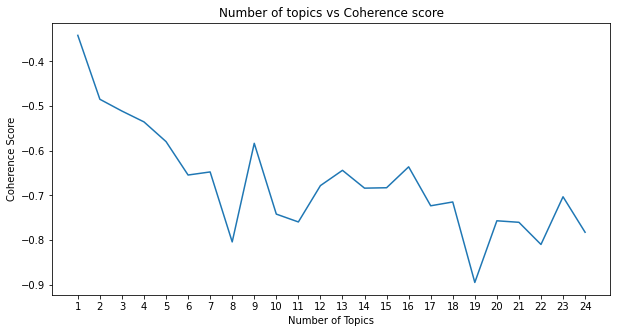

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Number of topics vs Coherence score")
plt.plot(range(1,25),words_coherence)
plt.xlabel("Number of Topics")
plt.xticks(range(1,25))
plt.ylabel("Coherence Score")

From the new pre processed text we see that the nnumber topics 9 has the best coherence value. Lets use this value and build the model and try to visualize it.

Surprisingly thats the same number as before lets see how clear words we can see with the lemmatized and bigrams.

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
NUM_TOPICS = 9 #based on the previous graph we see that 11 is the best number of topics after number 7
chunksize = 200 #passing 200 documents at a time to model for processing
passes = 20
iterations = 400
eval_every = None  # not evaluating the model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary_sec[0]  # This is only to "load" the dictionary.
id2word_sec = dictionary_sec.id2token

model_sec = LdaModel(
    corpus=corpus_sec,
    id2word=id2word_sec,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model{NUM_TOPICS}.gensim'
#print("Saving model in " + outputfile)
#print("")
#model.save(outputfile)

#### Visualization

Visualizing the LDA model 2 that we have generated

In [ ]:
#!pip install pyLDAvis
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(model_sec, corpus_sec, dictionary_sec, sort_topics=True)
pyLDAvis.display(lda_display)

Looking at the different topics that have been formed above we see that most of them talk about the corona virus cases. Like if you take **topic 1** by seeing the top words in that topic talks old aged people testing more postive who may be returne from Iran, Dubai or overseas.

One of the interesting topic found is **topic 6** about bush fires research. It says that bushfires affected lot of climate change the air quality has been bad. Monash university researchers and scientists doing their anlysis with data.

**Topic 5** tells more the airplanes, travelling at the time of Christmas

**Topic 9** mostly talks about the quarantine and self isolation of chinese people who have travelled and the number of chinese people affected


**Topic 8** talks about the `Diamond pricess` cruise, its route from the Tokyo and shows information about people boarder,tested positive

**Topic 7** is all about the school, student, univerisity ban, international travel ban that Mr.Scott Morrison had declared.

**Topic 4** Tells about the pandemic virus that being spread all over the world and news related to it and also the history and emergence of corona

**Topic 3** This is about the safety precautions that need to taken care to avoid corona

**Topic 2** Talks about the people travelled recently and affected with the corona

**Topic 1** This topic tells more about the places where people has travelled and the positive tested cases of corona



